# Centiment Analysis Challange
## Centiment.io
###Akshay Vaghani

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import nltk
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import string
import textblob as tb

# Analysed json file and extract emotion and persanality 
#think about how this emotions and persanality are connected with the Brands and our perceptions

In [3]:
# read jason file
import json
from pprint import pprint

with open('interview_sample_data.json') as f:
    data = json.load(f)

#pprint(data)

In [4]:
data.keys()

dict_keys(['personality', '0', '1', 'tweets', 'emotions', 'wh'])

### Extract emotions

- Emotion extraction from jason file indicates that joy is the highest emotion score for Nike brand. This also make sence as Nike is the sports brand and sports is related to energetic, joy and happy.

- There is also relatively high value of sadness is making questions on overall peoples emotions about the brand. It would be intersting to do further research on sadness score is relatively high. If people feels sad about Nike then its early alarm about the company to change their staratagy. 


In [5]:
# emotion extraction, only top five emotions
data['0']['sentiment']
test=data['0']['sentiment'].copy()
# remove key value 'full_array'
test.pop('full_array')
test=pd.DataFrame([test])
test=test.T
test.reset_index(inplace=True)
test.columns = ['emotions','score']
test.head()

,emotions,score
0,anger,0.019651
1,disgust,0.015820
2,fear,0.016627
3,joy,0.045838
4,sadness,0.030476


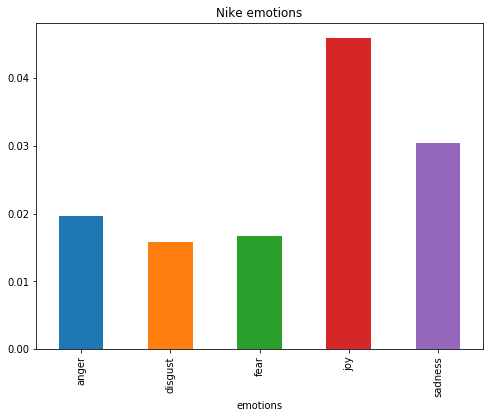

In [6]:
# plot emotions
test.plot(x='emotions', y='score',kind='bar',figsize=(8,6), title='Nike emotions', legend=False, style=None, )

### Extract personality

- I extracted the personality type of the json file and make the data table for easy review. I ploted personality score and it indicates that Emotional range, openness, orderliness, and practicality has highest score. While Trust, sympathy, love, self afficacy,imagination, emotionality, altriism,and assertivness has very low score. 

- It could be more helpful if I have some background information to analsysed this data further. 


In [7]:
temp=data['personality']
#temp

In [8]:
# extract personality and present in terms of dataframe or more readableway
# we can save file in .npz for easy transfer data as follow
# np.savez("data_person.npz",data['personality'])

In [9]:
# converting list of list to dictionairy 
emo_dict={}
for ele in temp:
    #print(ele)
    if type(ele) is dict:
        for keys,values in ele.items():
            emo_dict[keys]=values
    else:
        #print(ele[0],ele[1])
        for keys,values in zip(ele[0],ele[1]):
            emo_dict[keys]=values

# emo_dict

In [10]:
# convert dictionairy to dataframe
tem=pd.DataFrame([emo_dict])
tem=tem.T
tem.reset_index(inplace=True)
tem.columns = ['personality','score']
tem.head()

,personality,score
0,Achievement striving,0.141372
1,Activity level,0.464389
2,Adventurousness,0.247495
3,Agreeableness,0.435779
4,Altruism,0.00466407


In [11]:
# separate numerical scores and lists 
tem_num=tem[~tem.score.apply(lambda x: isinstance(x, list))]
tem_list=tem[tem.score.apply(lambda x: isinstance(x, list))]


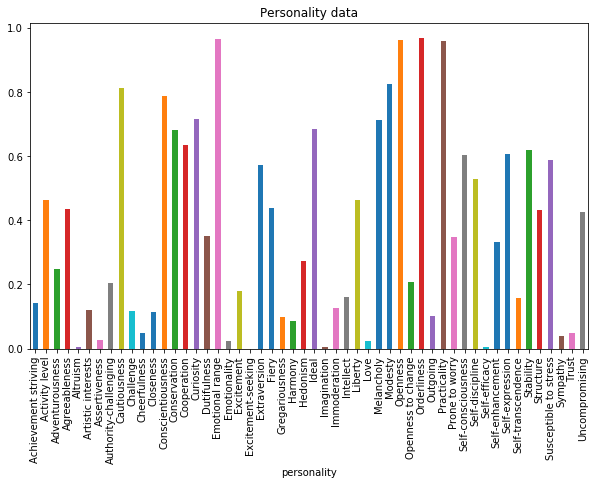

In [55]:
tem_num.plot(x='personality', y='score',kind='bar',figsize=(10,6), title='Personality data', legend=False, style=None,sort_columns=True )

In [57]:
# following list indicate personality type and most likey they would do some type of actions.
#pprint(tem_list)
tem_list

,personality,score
19,Entrepreneurship Preferences,[IS likely to consider starting a business in ...
20,Environmental Concern Preferences,[Is QUITE likely to be concerned about the env...
27,Health & Activity Preferences,"[IS NOT likely to eat out frequently, IS NOT l..."
37,Movie Preferences,"[IS NOT likely to like romance movies, IS NOT ..."
38,Music Preferences,"[IS likely to like rap music, Is QUITE likely ..."
45,Purchasing Preferences,[IS NOT likely to be sensitive to ownership co...
46,Reading Preferences,"[IS NOT likely to read often, IS NOT likely to..."
59,Volunteering Preferences,[IS NOT likely to volunteer for social causes]


# Predictive model for emotion analysis 

- From given 40k rows of the tweets with labeled emotions, I build NLP classsification models.

- In this note, I created overall framework to approch problem. Each section can be improve for future to get better accuracy and more specific implimentation.

- I started with basic visualization to see what emotions are frequently labled in our dataset. It shows that neutral,worry, happiness, sadness, and love are the top 5 emotions in our data set. I plotted same with with bar chart and Tree plot. 

- Then I made word cloud to see which words in tweets appeares most. It seems Love, Quot, and now appeares too frequently.

## Basic EDA and visualization

In [58]:
# read data
df = pd.read_csv('./interview_emotion_data.csv')

In [59]:
df.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [60]:
df.shape

(40000, 4)

In [61]:
for i in df.columns:
    print(i, "unique values ----> ",len(df[i].unique()))

tweet_id unique values ---->  40000
sentiment unique values ---->  13
author unique values ---->  33871
content unique values ---->  39827


In [62]:
for i in df.columns:
    print(i, "% null values are ----> ",100*df[df[i].isnull()].shape[0] / df.shape[0])

tweet_id % null values are ---->  0.0
sentiment % null values are ---->  0.0
author % null values are ---->  0.0
content % null values are ---->  0.0


In [63]:
df.sentiment.unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

Text(0,0.5,'Count')

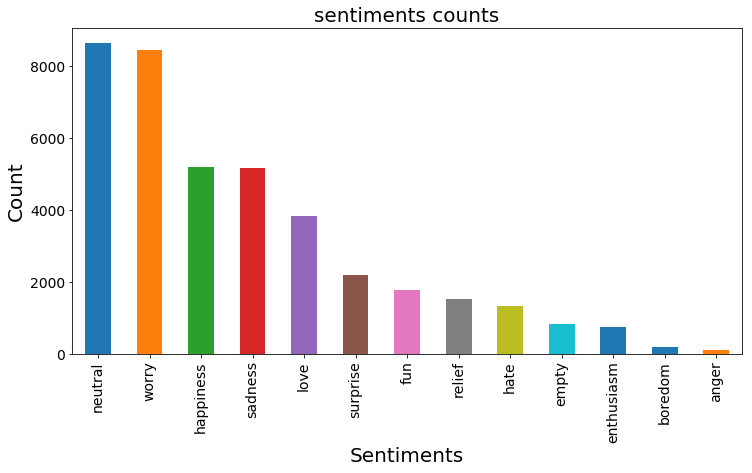

In [64]:
# sentiments counts
ax = df['sentiment'].value_counts().plot.bar(figsize = (12,6),fontsize = 14)
ax.set_title("sentiments counts", fontsize = 20)
ax.set_xlabel("Sentiments", fontsize = 20)
ax.set_ylabel("Count", fontsize = 20)

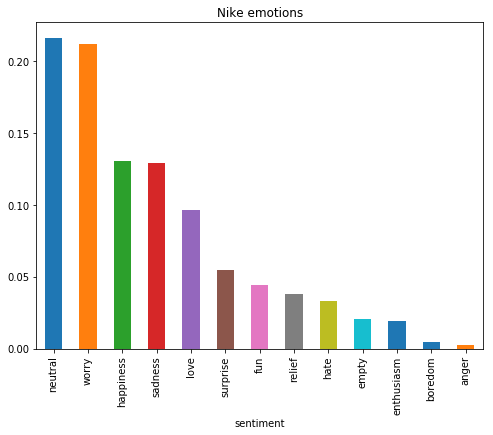

In [65]:
# percentage of individual emotions counts in data sets
test=df.sentiment.value_counts(2).reset_index().rename(columns={'index': 'sentiment', 'sentiment': 'count'})
test.head()
test.plot(x='sentiment', y='count',kind='bar',figsize=(8,6), title='Nike emotions', legend=False, style=None, )

## Tree map

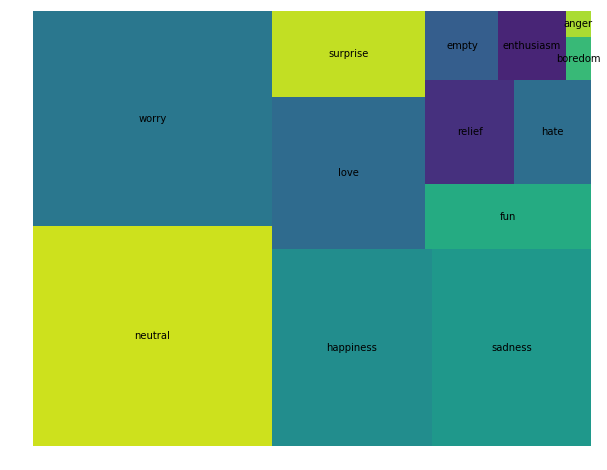

In [66]:
# tree map for size of the emotion counts 
import pandas as pd
import squarify
from matplotlib import cm
plt.figure(figsize=(10,8))
squarify.plot(sizes=test['count'], label=test['sentiment'],alpha=1)
plt.axis('off')
plt.show()

## Word cloud 

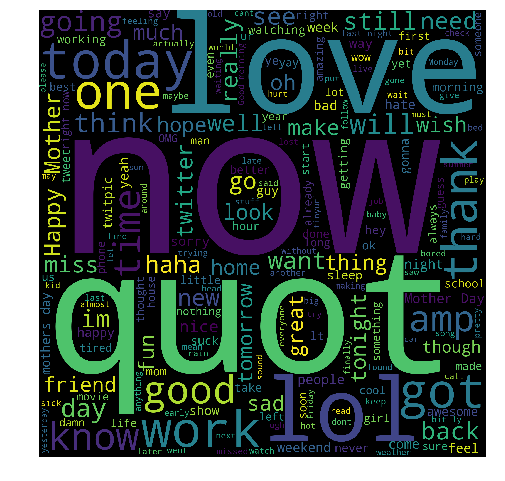

In [23]:
# word cloud 
# most frequesnt words in commnets 
df_content = df['content']

def showWordCloud(data):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(stopwords = STOPWORDS,
                         background_color = 'black',
                         width = 2500,
                         height = 2500
                         ).generate(cleaned_word)
    plt.figure(1,figsize = (8,10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

showWordCloud(df_content)


# Building the NPL model for emotion classification

- first, we preprocess the text data to remove unnecessary words, symboles, spaces etc and then we did feature engineering to covert text data to numerical data. Finally we pass numerical data(sparce matrix) in to machine learning algorithm to classify the emotions.

In [24]:
# import library
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akshay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
df.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


# Text preprocessing 

### Clean the text/documents

- Here, we manually clean then text data by removing specially characters, lowering case, removing suffix but keeping meaning full words. 

- Some feature enginnering built in functions in sklearn or NLTK also clean the the text 



In [30]:
# clean the texts
corpus = []
for i in range(0, len(df)):
    review = re.sub('[^a-zA-Z]', ' ', df['content'][i]) # match all strings that start with a letter, the second means match all strings that contain a non-letter
    review = review.lower() # lower case
    review = review.split() # split words
    wl = WordNetLemmatizer()  # bettwer way to remove suffix by keping meaning full words
    # remove most common english words in sentece 
    review = [wl.lemmatize(word) for word in review if not word in set(stopwords.words('english'))] # aslo stops most common english words such as a,an, the in ,on etc
    review = ' '.join(review)
    corpus.append(review)
    
# corpus

# Feature Engineering 

### considering document level only ( word and sentence level didnt considered here, may be try for future )

In [31]:
# import the library 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


### Countvectorization (bag of words model)

- Count Vector is a matrix notation of the text dataset.
- every row represents a each document/tweets from the corpus
- every column represents a unique word(term) from the corpus
- every cell represents the frequency count of a particular word(term) in a particular document

In [32]:
# count the word frequesncy in each documents 
cv = CountVectorizer(min_df=0., max_df=1.)
X = cv.fit_transform(df['content'])
y = df.sentiment.values
class_names = df.sentiment.unique()

### Countvectorization ( n-gram model)

In [33]:
# count the frequesncy of n words togather in documents(rows)
cv = CountVectorizer(ngram_range=(1,2))
X = cv.fit_transform(df['content'])
y = df.sentiment.values
class_names = df.sentiment.unique()

### TF-IDF vectorization

- 'bag of wors' some terms occure many time accross the all documents/rows and it might overshadow other temrs in feature space

- TF-IDF score represents the relative importance of a term in the document and the entire corpus.

- TF-IDF score is composed by two terms: (1) normalized Term Frequency (TF), (2) Inverse Document Frequency (IDF)

- TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)

- IDF =logarithm(the number of the documents in the corpus/the number of documents where the specific term appears)


In [34]:
# TF-IDF vectorization
tf = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
# considering bigram, and removing most common english words
#tf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
X = tf.fit_transform(df['content'])
y = df.sentiment.values
class_names = df.sentiment.unique()


### Document similarity
#Cautions-it take too long time 

- Document similarity is the process of using distance of similarity base matric 
- identify how similar text document is with any other documents base on feature extarction from then ag of words or TF-IDF
- generate new feature on top of TF-IDF and use clustering techniques to find similar features
- if we have c documents(rows) then we get c*c matrix (similarity matrix)
- similarity score calculated base on Cosine distance , euclidian distacne, manhattan distance, Jaccord distance, BM25 similarity etc
- cosine similarity gives matric represnting the cosine angle betn two documents


In [ ]:
# this takes too long time to run, make sure before starts

#similarity_matrix = cosine_similarity(X)
#similarity_df = pd.DataFrame(similarity_matrix)
#similarity_df.head()

In [ ]:
# this takes too long time to run, make sure before starts

from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(similarity_matrix, 'ward')
pd.DataFrame(Z, columns=['Cluster 1', 'Cluster 2', 
                         'Distance', 'Cluster Size'], dtype='object')

In [ ]:
from scipy.cluster.hierarchy import fcluster
max_dist = 1.0

cluster_labels = fcluster(Z, max_dist, criterion='distance')
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

### Topic modelings

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_topics=3, max_iter=1000, random_state=0)
dt_matrix = lda.fit_transform(cv_matrix)
features = pd.DataFrame(dt_matrix, columns=['T1', 'T2', 'T3'])
features

In [ ]:
# clustering topics base on topics models features
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(features)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

# Classification modeling

### train-test split

In [68]:
# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 0)

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB,label_binarize,LabelBinarizer
from sklearn.svm import LinearSVC, SVC,libsvm_sparse
from sklearn.model_selection import cross_val_score

### Logistic regression

- Logistic regression measures the relationship between the categorical dependent variable and one or more independent variables by estimating probabilities using a logistic/sigmoid function. 

In [38]:
#Logistic
model = LogisticRegression(random_state=0,solver='lbfgs',class_weight='balanced',multi_class='multinomial')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

             precision    recall  f1-score   support

      empty       0.00      0.00      0.00        27
    sadness       0.03      0.15      0.05        47
 enthusiasm       0.03      0.12      0.05       188
    neutral       0.03      0.13      0.05       184
      worry       0.13      0.26      0.17       431
   surprise       0.33      0.21      0.26      1312
       love       0.18      0.40      0.25       302
        fun       0.49      0.45      0.47       976
       hate       0.38      0.22      0.28      2176
  happiness       0.11      0.22      0.14       367
    boredom       0.32      0.24      0.28      1326
     relief       0.11      0.17      0.14       544
      anger       0.40      0.19      0.26      2120

avg / total       0.32      0.24      0.26     10000



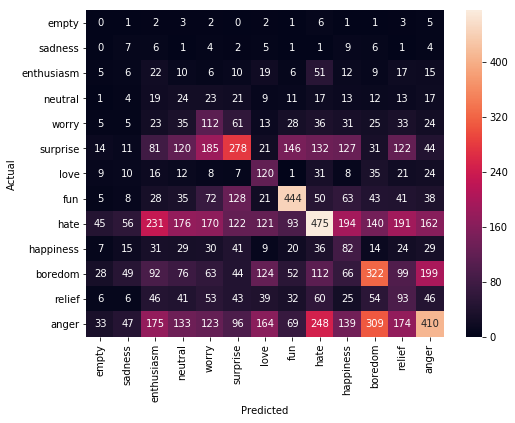

In [39]:
# matrix to measure classification
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# print classification scores 
print(metrics.classification_report(y_test, y_pred,target_names=class_names))

# print confusion matric
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Multinomial Naive bases 

- Naive Bayes is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors.

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

      empty       0.00      0.00      0.00        27
    sadness       0.00      0.00      0.00        47
 enthusiasm       0.00      0.00      0.00       188
    neutral       0.00      0.00      0.00       184
      worry       1.00      0.00      0.00       431
   surprise       0.33      0.23      0.27      1312
       love       0.00      0.00      0.00       302
        fun       0.56      0.25      0.35       976
       hate       0.29      0.55      0.38      2176
  happiness       0.00      0.00      0.00       367
    boredom       0.30      0.09      0.14      1326
     relief       0.00      0.00      0.00       544
      anger       0.30      0.58      0.39      2120

avg / total       0.31      0.31      0.25     10000



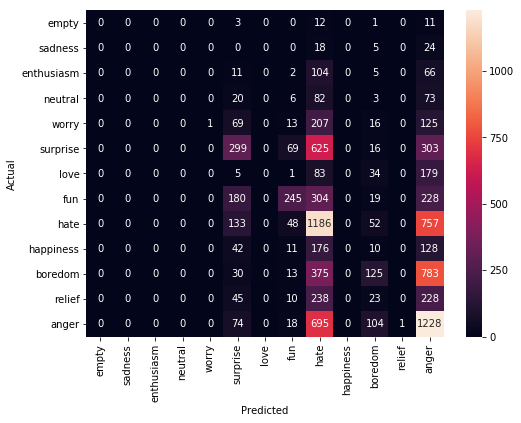

In [40]:
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


# print classification scores 
print(metrics.classification_report(y_test, y_pred,target_names=class_names))

# print confusion matric
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Linear SVC

- The SVM model extracts a best possible hyper-plane / line that segregates the two or more class classes.

             precision    recall  f1-score   support

      empty       0.00      0.00      0.00        27
    sadness       0.00      0.00      0.00        47
 enthusiasm       0.03      0.01      0.02       188
    neutral       0.05      0.01      0.02       184
      worry       0.09      0.05      0.07       431
   surprise       0.29      0.30      0.29      1312
       love       0.21      0.16      0.18       302
        fun       0.40      0.37      0.38       976
       hate       0.32      0.44      0.37      2176
  happiness       0.15      0.07      0.10       367
    boredom       0.26      0.24      0.25      1326
     relief       0.11      0.05      0.07       544
      anger       0.33      0.39      0.36      2120

avg / total       0.27      0.30      0.28     10000



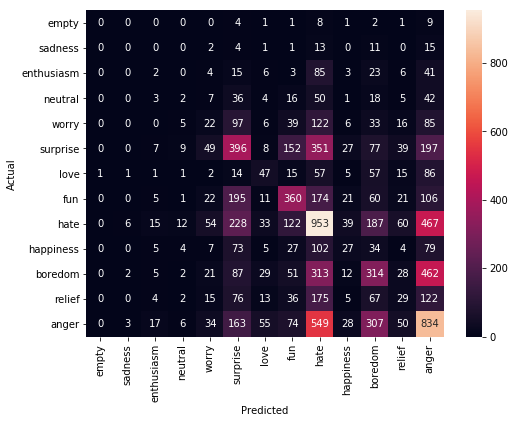

In [41]:
# Linear SVC looks much faster then SVC
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


# print classification scores 
print(metrics.classification_report(y_test, y_pred,target_names=class_names))

# print confusion matric
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Random forest classifiers

- Random Forest models are a type of ensemble models, particularly bagging models. They are part of the tree based model family. 

             precision    recall  f1-score   support

      empty       0.00      0.04      0.01        27
    sadness       0.03      0.38      0.05        47
 enthusiasm       0.03      0.40      0.05       188
    neutral       0.03      0.12      0.04       184
      worry       0.14      0.25      0.18       431
   surprise       0.30      0.11      0.16      1312
       love       0.21      0.31      0.25       302
        fun       0.37      0.41      0.39       976
       hate       0.27      0.12      0.17      2176
  happiness       0.13      0.15      0.14       367
    boredom       0.37      0.17      0.23      1326
     relief       0.12      0.08      0.10       544
      anger       0.41      0.08      0.13      2120

avg / total       0.29      0.16      0.18     10000



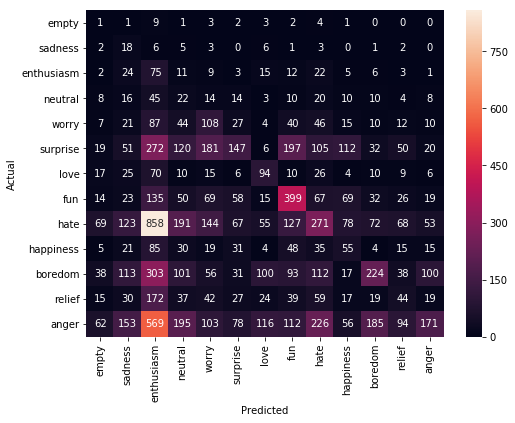

In [42]:
model = RandomForestClassifier(n_estimators=500, max_depth=5,class_weight='balanced',criterion='entropy',random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


# print classification scores 
print(metrics.classification_report(y_test, y_pred,target_names=class_names))

# print confusion matric
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Stocastic Gradiaent decent classifiers (SGC)

- Just experiemtn with this classifiers

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

      empty       0.00      0.00      0.00        27
    sadness       0.00      0.00      0.00        47
 enthusiasm       0.00      0.00      0.00       188
    neutral       0.04      0.05      0.04       184
      worry       0.15      0.03      0.05       431
   surprise       0.33      0.17      0.23      1312
       love       0.35      0.11      0.17       302
        fun       0.44      0.49      0.46       976
       hate       0.33      0.51      0.40      2176
  happiness       0.18      0.03      0.06       367
    boredom       0.27      0.28      0.28      1326
     relief       0.09      0.03      0.05       544
      anger       0.33      0.42      0.37      2120

avg / total       0.29      0.32      0.29     10000



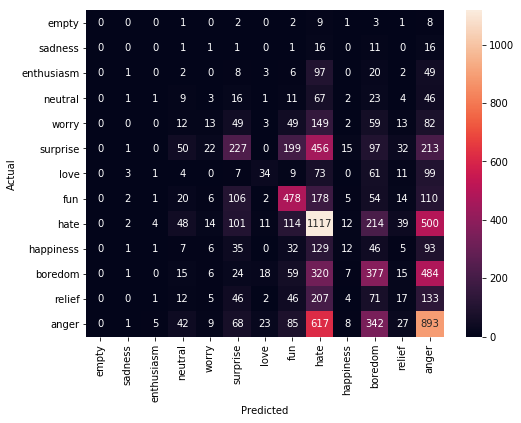

In [43]:
# SGC classifier
from sklearn.linear_model import SGDClassifier
model=SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, n_iter=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


# print classification scores 
print(metrics.classification_report(y_test, y_pred,target_names=class_names))

# print confusion matric
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

- With all classifers, I tried I got better score with logistic regression and Naive base. 

# Improve accuracy score - reducing the emotion category from 13 to 8

- By combining emotions and reducing total emotions to 8 we improve accuracy around 10%

### Combined the similar emotions
#'empty'='neutral','relief'='neutral',
#'love'='happiness','fun'='happiness','enthusiasm'='happiness',
#'boredom'='sadness'

In [46]:
#copy data frame
df1=df.copy()
df1.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


### Combining features


In [47]:
df1['sentiment']=df.sentiment.replace({'empty': 'neutral','relief':'neutral','love':'happiness','fun':'happiness','enthusiasm':'happiness','boredom':'sadness'},)
df1.sentiment.unique()

array(['neutral', 'sadness', 'happiness', 'worry', 'surprise', 'hate',
       'anger'], dtype=object)

#### TFIDF

In [50]:
# TFIDF is equivalent to countvectorized followed by TfidfTtransformer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
X = tfidf.fit_transform(df1.content).toarray()
y = df1.sentiment.values

#### Split the data set

In [51]:
# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 0)

#### Logistic regression

             precision    recall  f1-score   support

    neutral       0.00      0.00      0.00        27
    sadness       0.62      0.51      0.56      2903
  happiness       0.16      0.40      0.23       302
      worry       0.44      0.39      0.41      2731
   surprise       0.30      0.31      0.30      1373
       hate       0.10      0.23      0.14       544
      anger       0.37      0.29      0.32      2120

avg / total       0.43      0.38      0.40     10000



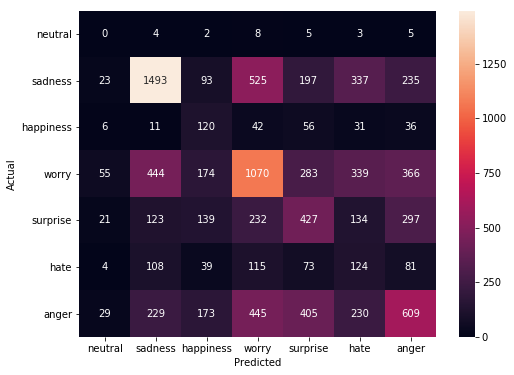

In [54]:
#Logistic regression
model = LogisticRegression(random_state=0,solver='lbfgs',class_weight='balanced',multi_class='multinomial')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
class_names = df1.sentiment.unique()


# matrix to measure classification
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# print classification scores 
print(metrics.classification_report(y_test, y_pred,target_names=class_names))

# print confusion matric
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Naive base

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

    neutral       0.00      0.00      0.00        27
    sadness       0.50      0.67      0.57      2903
  happiness       0.00      0.00      0.00       302
      worry       0.36      0.48      0.41      2731
   surprise       0.38      0.08      0.14      1373
       hate       0.00      0.00      0.00       544
      anger       0.37      0.37      0.37      2120

avg / total       0.37      0.42      0.37     10000



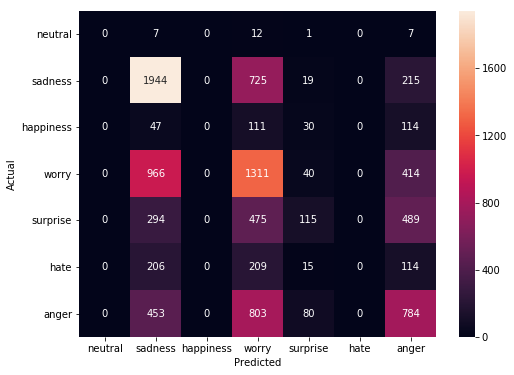

In [70]:
# naive base
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


# print classification scores 
print(metrics.classification_report(y_test, y_pred,target_names=class_names))

# print confusion matric
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Future direction

- During emotion analysis with given data, I have realised that accuratly classify 13 different emotions is challanging task. Standard NLP techniques doesnt help much to imporove accruacy. 


- I would also like to improve accuracy by tuning parameters by grid Search

- In future, I would like to try first Neural Network/Deep learning base techniques and see if accruacy improves 

- I would like to identify emotions base words with the context meaning from the sentence and model it. I mean collecting more frequesnt phrase or idioms in sentence represnt perticular emotions and model this
